<a href="https://colab.research.google.com/github/rooncal/Image-Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import cv2
import random
import torchvision.datasets as dset
import torchvision.transforms as T
from PIL import Image


from functools import reduce
import numpy as np
import os
import sys
from google.colab import drive
from glob import glob
import matplotlib.pyplot as plt

!pip install elasticdeform
import elasticdeform

In [2]:
%matplotlib inline

##Preparing the data

In [3]:
!git clone https://github.com/zhixuhao/unet.git
!mv unet/data/membrane/train .
!mv unet/data/membrane/test .
!rm -rf unet
!rm -rf train/aug

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (80/80), done.


##Loading the data

In [3]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform=None):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob(os.path.join(folder_path,'image/','*.png'))
        self.mask_files = glob(os.path.join(folder_path,'label/','*.png'))
        self.transform = transform

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = np.asarray(Image.open(img_path))
            label = np.asarray(Image.open(mask_path))
            if self.transform:
              transformed_data, transformed_label = self.transform(data,label)
              return torch.tensor(transformed_data).reshape(1,1,512,512).float(), torch.tensor(transformed_label).reshape(1,1,512,512).float()
            return torch.tensor(data).reshape(1,1,512,512).float(), torch.tensor(label).reshape(1,1,512,512).float()

    def __len__(self):
        return len(self.img_files)

In [4]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter



class ElasticTransform(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, sigma=10, alpha=1, alpha_affine=10, random_state=None):
      self.sigma = sigma
      self.alpha = alpha
      self.random_state = random_state
      self.alpha_affine = alpha_affine


    def __call__(self, image, mask):
      shape = image.shape
      print(shape)
      [image, mask] = elasticdeform.deform_random_grid([image, mask], sigma=self.sigma, points=[3,3], order=[3,3], zoom=1.5)
      return image, mask

In [5]:
class Compose(T.Compose):

    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask

In [6]:
transform = Compose([
                ElasticTransform()
            ])


loader_train = DataLoaderSegmentation(folder_path='/content/train', transform=transform)


In [105]:
loader_train[0]

(512, 512)


(tensor([[[[ 70.,  74., 116.,  ..., 156., 176., 167.],
           [102., 105., 126.,  ..., 166., 162., 155.],
           [135., 129., 132.,  ..., 160., 135., 131.],
           ...,
           [125., 110.,  99.,  ..., 122., 142., 138.],
           [117.,  89.,  75.,  ..., 121., 154., 141.],
           [122.,  94.,  81.,  ...,  83., 111., 106.]]]]),
 tensor([[[[254., 254., 254.,  ..., 123.,  90.,  38.],
           [254., 254., 254.,  ..., 110.,  96.,  82.],
           [254., 254., 254.,  ..., 113., 154., 164.],
           ...,
           [254., 254., 254.,  ..., 147., 101.,  77.],
           [254., 254., 254.,  ..., 110.,  72.,  58.],
           [254., 254., 254.,  ...,  33.,  21.,  17.]]]]))

(512, 512)


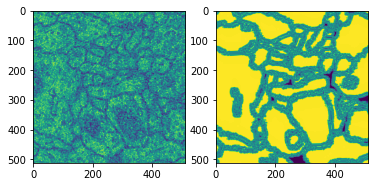

In [106]:
fig=plt.figure()
fig.add_subplot(1,2,1)
x,y = loader_train[0]
plt.imshow(x[0][0])
fig.add_subplot(1,2,2)
plt.imshow(y[0][0])
plt.show()

##Building the model

In [7]:
class TwoConvsDown(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels, in_channels*2, 3)
    self.conv2 = nn.Conv2d(in_channels*2, in_channels*2, 3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x


class TwoConvsUp(nn.Module):
  def __init__(self,in_channels):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels, in_channels//2, 3)
    self.conv2 = nn.Conv2d(in_channels//2, in_channels//2, 3)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

In [26]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1, 64, 3)
    self.conv2 = nn.Conv2d(64, 64, 3)
    self.twoconv1 = TwoConvsDown(64)
    self.twoconv2 = TwoConvsDown(128)
    self.twoconv3 = TwoConvsDown(256)
    self.twoconv4 = TwoConvsDown(512)
    self.twoconv5 = TwoConvsUp(1024)
    self.twoconv6 = TwoConvsUp(512)
    self.twoconv7 = TwoConvsUp(256)
    self.twoconv8 = TwoConvsUp(128)
    self.finalconv = nn.Conv2d(64,2,1)

    self.oneconv1 = nn.Conv2d(1024,512,1,1)
    self.oneconv2 = nn.Conv2d(512,256,1,1)
    self.oneconv3 = nn.Conv2d(256,128,1,1)
    self.oneconv4 = nn.Conv2d(128,64,1,1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    concat_1 = x
    x = nn.MaxPool2d(2,2)(x)

    x =self.twoconv1(x)
    concat_2 = x
    x = nn.MaxPool2d(2,2)(x)

    x = self.twoconv2(x)
    concat_3 = x
    x = nn.MaxPool2d(2,2)(x)
    x = self.twoconv3(x)
    
    concat_4 = x
    x = nn.MaxPool2d(2,2)(x)
    x = self.twoconv4(x)
    x = nn.Upsample(size=56, mode='bilinear', align_corners=True)(x)
    x = self.oneconv1(x)
    
    x = torch.cat((concat_4, x), 1)
    x = self.twoconv5(x)

    x = nn.Upsample(size=121, mode='bilinear', align_corners=True)(x)
    x = self.oneconv2(x)
    x = torch.cat((concat_3, x), 1)
    x = self.twoconv6(x)

    x = nn.Upsample(size=250, mode='bilinear', align_corners=True)(x)
    x = self.oneconv3(x)
    x = torch.cat((concat_2, x), 1)
    x = self.twoconv7(x)

    x = nn.Upsample(size=508, mode='bilinear', align_corners=True)(x)
    x = self.oneconv4(x)
    x = torch.cat((concat_1, x), 1)
    x = self.twoconv8(x)

    x = self.finalconv(x)
    
    return x

In [27]:
x = torch.zeros((1, 1, 512, 512), dtype=torch.float32)
model = Unet()
scores = model(x)
print(scores.size())  

torch.Size([1, 2, 504, 504])


In [28]:
model = Unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.cuda(device)

Unet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (twoconv1): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (twoconv2): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (twoconv3): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  )
  (twoconv4): TwoConvsDown(
    (relu): ReLU()
    (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
  )
  (twoconv5): TwoConvsUp(
    (relu): ReLU()
    (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d

In [35]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels.long()[0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

(512, 512)


RuntimeError: ignored